<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [19]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [21]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [24]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-01 10:46:54
Mean Train Loss: 0.07694732171417974
Mean Evaluation Loss: 0.07904056045611167
-------------------------------------------------------------------------------------------------------
09-01 10:47:15
Mean Train Loss: 0.07607432832945428
Mean Evaluation Loss: 0.07824595949631465
-------------------------------------------------------------------------------------------------------
09-01 10:47:35
Mean Train Loss: 0.07526075951024137
Mean Evaluation Loss: 0.07647157232958354
-------------------------------------------------------------------------------------------------------
09-01 10:47:55
Mean Train Loss: 0.07458809435280968
Mean Evaluation Loss: 0.07550488110772433
-------------------------------------------------------------------------------------------------------
09-01 10:48:15
Mean Train Loss: 0.07370174923858844
Mean Evaluation Loss: 0.0743691184170569
-----------------------------------------------------------------------------------------------------

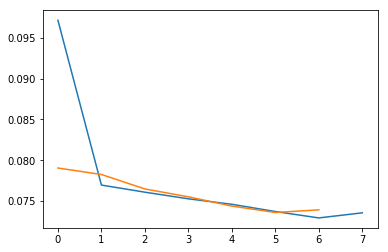

아ᄂ------------------------------------------------------------------------------------------------------------------------------------------ᆻᄃ다ᅡ--------------------------------------.<eos><eos>
아ᄂᆻ다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


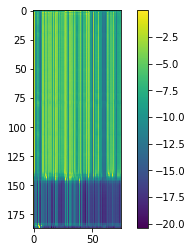

아ᄂ-------------------------------------------------------------------------------------------------ᄋ-ᆻᆻ다ᅡ------------------------------------------------.<eos><eos>
아ᄂᄋᆻ다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


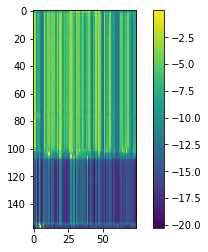

-------------------------------------------------------------------------------------------------------
09-01 10:49:18
Mean Train Loss: 0.07242183833497681
Mean Evaluation Loss: 0.07255850421265435
-------------------------------------------------------------------------------------------------------
09-01 10:49:38
Mean Train Loss: 0.07153775831178398
Mean Evaluation Loss: 0.07224927870423306
-------------------------------------------------------------------------------------------------------
09-01 10:49:58
Mean Train Loss: 0.07094113463469383
Mean Evaluation Loss: 0.06860278508319995
-------------------------------------------------------------------------------------------------------
09-01 10:50:18
Mean Train Loss: 0.0708024868858408
Mean Evaluation Loss: 0.07650696253688863
-------------------------------------------------------------------------------------------------------
09-01 10:50:39
Mean Train Loss: 0.07283819254326736
Mean Evaluation Loss: 0.07291589313045228
-----------

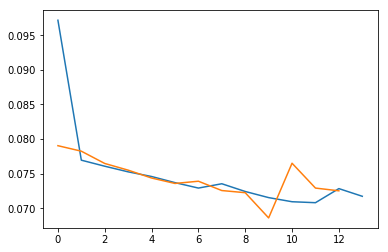

아느---------------------------------------------------------------------------------------------------------------------------------앴ᄃ다---------------------------------------------.<eos><eos>
아느앴다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


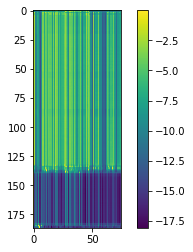

아느-------------------------------------------------------------------------------------------------았어요-----------------------------------------------.<eos><eos>
아느았어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


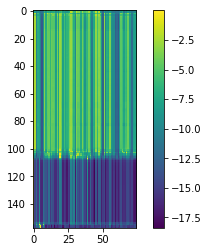

-------------------------------------------------------------------------------------------------------
09-01 10:51:19
Mean Train Loss: 0.07155711993357462
Mean Evaluation Loss: 0.07218990662717067
-------------------------------------------------------------------------------------------------------
09-01 10:51:40
Mean Train Loss: 0.07111832695032554
Mean Evaluation Loss: 0.07138947680062571
-------------------------------------------------------------------------------------------------------
09-01 10:52:00
Mean Train Loss: 0.06812396183943493
Mean Evaluation Loss: 0.06475502119022078
-------------------------------------------------------------------------------------------------------
09-01 10:52:20
Mean Train Loss: 0.06666023913139407
Mean Evaluation Loss: 0.06373218185451615
-------------------------------------------------------------------------------------------------------
09-01 10:52:41
Mean Train Loss: 0.061293192620842554
Mean Evaluation Loss: 0.06516396178147178
---------

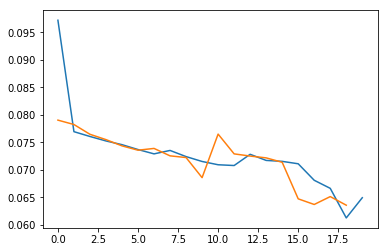

어------ᅳ--으-------ᄋ--아--아--아---ᅳ---ᄋ----으---아----으--아---ᅳ----아--아--아--으--아--아--ᄋ---아--아---ᅳ--아--아--아--아--아--으------------------------------------------------요--.<eos><eos>
어ᅳ으ᄋ아아아ᅳᄋ으아으아ᅳ아아아으아아ᄋ아아ᅳ아아아아아으요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


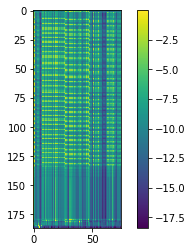

어----------ᅡ----아--아--아--아--아--아--아--아--아--아--아--아---아--아--아--아--아--아--아--아--아--아--아------------------------------------------ᅥ요--.<eos><eos>
어ᅡ아아아아아아아아아아아아아아아아아아아아아아아ᅥ요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


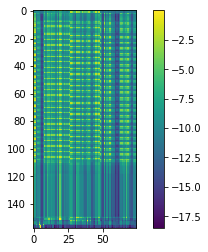

-------------------------------------------------------------------------------------------------------
09-01 10:53:21
Mean Train Loss: 0.06200616123659423
Mean Evaluation Loss: 0.0623827886124117
-------------------------------------------------------------------------------------------------------
09-01 10:53:41
Mean Train Loss: 0.06157398040146341
Mean Evaluation Loss: 0.06429731018572718
-------------------------------------------------------------------------------------------------------
09-01 10:54:02
Mean Train Loss: 0.0636355419796055
Mean Evaluation Loss: 0.07295723723549134
-------------------------------------------------------------------------------------------------------
09-01 10:54:23
Mean Train Loss: 0.07069212825264468
Mean Evaluation Loss: 0.06802385447697708
-------------------------------------------------------------------------------------------------------
09-01 10:54:43
Mean Train Loss: 0.0658713783635181
Mean Evaluation Loss: 0.06514485170083242
-------------

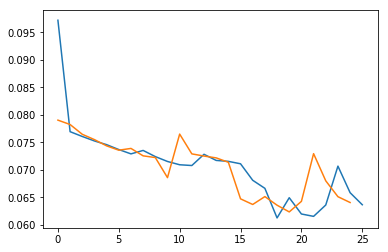

아-----------ᅳ-------아-으--아-아--아---아--아-아-아---------아--아-아--아-아-아-아--아-아--아--아--아--아--ᄋ--아-아--아---아------------------------------------------------------ᅥ요--.<eos><eos>
아ᅳ아으아아아아아아아아아아아아아아아아아아아아ᄋ아아아아ᅥ요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


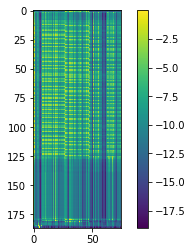

아---------------------으--ᅡ--아-아--아--아--ᅡ--아--아--ᅡ---ᅡ--아--아--ᅡ-----아--ᅡ--아--ᅡ--아--아--ᅡ--아-아--ᄋ--아-아--아-----------------------------ᅵ다--.<eos><eos>
아으ᅡ아아아아ᅡ아아ᅡᅡ아아ᅡ아ᅡ아ᅡ아아ᅡ아아ᄋ아아아ᅵ다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


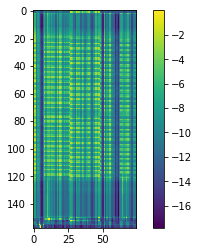

-------------------------------------------------------------------------------------------------------
09-01 10:55:24
Mean Train Loss: 0.06330503363418076
Mean Evaluation Loss: 0.06849177130228794
-------------------------------------------------------------------------------------------------------
09-01 10:55:45
Mean Train Loss: 0.0642105043292567
Mean Evaluation Loss: 0.06467571380307928
-------------------------------------------------------------------------------------------------------
09-01 10:56:05
Mean Train Loss: 0.06262512538073221
Mean Evaluation Loss: 0.061784167244556404
-------------------------------------------------------------------------------------------------------
09-01 10:56:25
Mean Train Loss: 0.06170694691241896
Mean Evaluation Loss: 0.061762457061835384
-------------------------------------------------------------------------------------------------------
09-01 10:56:45
Mean Train Loss: 0.061451248423971774
Mean Evaluation Loss: 0.06577954904035921
--------

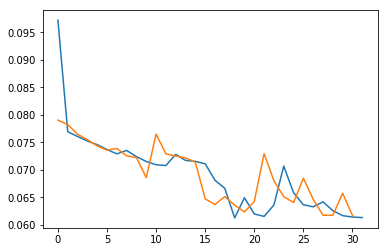

아-----------ᅳ--으---으--아--으--아--아--아---아--아---아--아--아--아-아----ᅡ---아-----아--아--아---------아--아--아--아---아--아--아-----------------------------ᆻ다--.<eos><eos>
아ᅳ으으아으아아아아아아아아아아ᅡ아아아아아아아아아아았다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


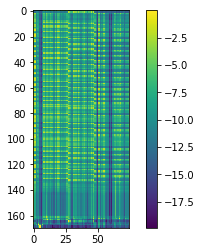

아--------------ᅳ--으--아--아----ᅡ--아--아---아--아--아--아--아---아--아---아--아--아----ᅡ--아--아--아--아---아--아-----------------------------------ᆻ다--.<eos><eos>
아ᅳ으아아ᅡ아아아아아아아아아아아아ᅡ아아아아아았다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


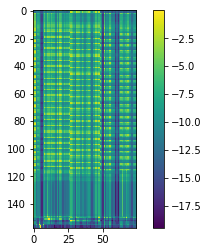

-------------------------------------------------------------------------------------------------------
09-01 10:57:26
Mean Train Loss: 0.06105095008360785
Mean Evaluation Loss: 0.06366221760646623
-------------------------------------------------------------------------------------------------------
09-01 10:57:46
Mean Train Loss: 0.061144525835523565
Mean Evaluation Loss: 0.06570156758241
-------------------------------------------------------------------------------------------------------
09-01 10:58:06
Mean Train Loss: 0.06099913711480589
Mean Evaluation Loss: 0.06535622186007171
-------------------------------------------------------------------------------------------------------
09-01 10:58:26
Mean Train Loss: 0.06084651680027346
Mean Evaluation Loss: 0.06338377196622028
-------------------------------------------------------------------------------------------------------
09-01 10:58:47
Mean Train Loss: 0.06068686035109931
Mean Evaluation Loss: 0.06399491261313345
------------

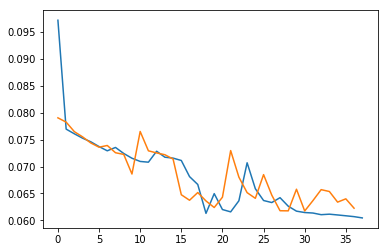

아-----------ᅳ---으----아-------아--아--아--아--아----------아----아--아--아----아---아----아--아---아--아--아---아--아-----아-----------------------------------어요--.<eos><eos>
아ᅳ으아아아아아아아아아아아아아아아아아아아아어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


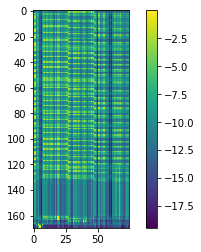

아--------------으--으--으--으--이--으--으--이--이---이--이--이--이--아--아--아--아--이--이--아--아---아----------------------------------------------ᆻ다--.<eos><eos>
아으으으으이으으이이이이이이아아아아이이아아았다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


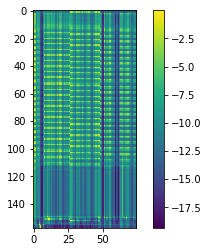

-------------------------------------------------------------------------------------------------------
09-01 10:59:27
Mean Train Loss: 0.06090908256840664
Mean Evaluation Loss: 0.06201414243208486
-------------------------------------------------------------------------------------------------------
09-01 10:59:48
Mean Train Loss: 0.06055222015595677
Mean Evaluation Loss: 0.06299583827069226
-------------------------------------------------------------------------------------------------------
09-01 11:00:08
Mean Train Loss: 0.06063558191860296
Mean Evaluation Loss: 0.06886292043813307
-------------------------------------------------------------------------------------------------------
09-01 11:00:28
Mean Train Loss: 0.0608212813147265
Mean Evaluation Loss: 0.0657589051395877
-------------------------------------------------------------------------------------------------------
09-01 11:00:48
Mean Train Loss: 0.06046985573469981
Mean Evaluation Loss: 0.0647779812265356
-------------

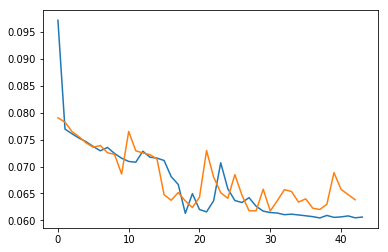

아--------------아--아---아--아---아---아--아----아----아--------아--아----아---아--아---아---아--아---아----아--아-------아--아--아-----------------------------------------------ᆻ다--.<eos><eos>
아아아아아아아아아아아아아아아아아아아아아아아았다.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


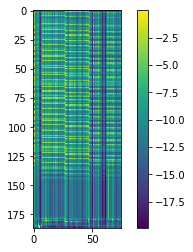

아---------아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--------------------------------------------니다--.<eos><eos>
아아아아아아아아아아아아아아아아아아아아아아아아아니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


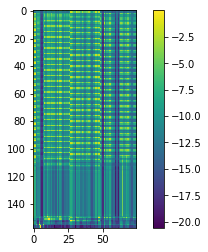

-------------------------------------------------------------------------------------------------------
09-01 11:01:30
Mean Train Loss: 0.06009186381569049
Mean Evaluation Loss: 0.06098926817737006
-------------------------------------------------------------------------------------------------------
09-01 11:01:50
Mean Train Loss: 0.06020138101793365
Mean Evaluation Loss: 0.06110282456007773
-------------------------------------------------------------------------------------------------------
09-01 11:02:10
Mean Train Loss: 0.05978604874659964
Mean Evaluation Loss: 0.061405109724020954
-------------------------------------------------------------------------------------------------------
09-01 11:02:30
Mean Train Loss: 0.05985029893842025
Mean Evaluation Loss: 0.060484487960099524
-------------------------------------------------------------------------------------------------------
09-01 11:02:51
Mean Train Loss: 0.05966625556557081
Mean Evaluation Loss: 0.05876051107750107
--------

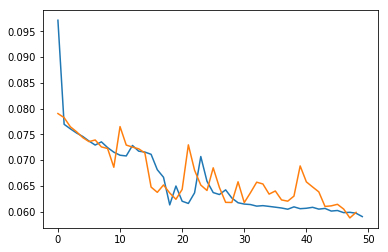

어----------아--아--아--아---아-------아----아--아--으-----아--아--아-----아---아----아--아--아--아----아---어----아--아--아------------------------------------------------------어요--.<eos><eos>
어아아아아아아아아으아아아아아아아아아아어아아아어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


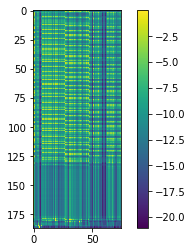

어-----------------ᅡ--아--아--아--아--아--아--아--아--아--아--이--아--아--아--아--아--아--아--아--아--아--이-----------------------------------------어요--.<eos><eos>
어ᅡ아아아아아아아아아아이아아아아아아아아아아이어요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


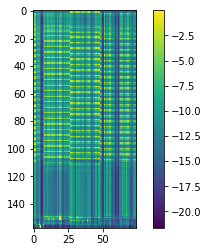

-------------------------------------------------------------------------------------------------------
09-01 11:03:32
Mean Train Loss: 0.05921132493309058
Mean Evaluation Loss: 0.05985151800073082
-------------------------------------------------------------------------------------------------------
09-01 11:03:52
Mean Train Loss: 0.05934132231074579
Mean Evaluation Loss: 0.058555760921498896
-------------------------------------------------------------------------------------------------------
09-01 11:04:12
Mean Train Loss: 0.059004901595742044
Mean Evaluation Loss: 0.05936203577938152
-------------------------------------------------------------------------------------------------------
09-01 11:04:32
Mean Train Loss: 0.058557616648306485
Mean Evaluation Loss: 0.05857417886371313
-------------------------------------------------------------------------------------------------------
09-01 11:04:53
Mean Train Loss: 0.05869619810465487
Mean Evaluation Loss: 0.05935191885591533
-------

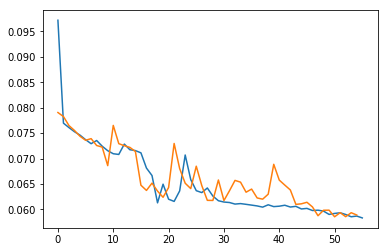

어--------------으----아---ᅡ-아--아---아----아---아----아--으--아--오--아---아----오--아----아---아---아----아----아---아----이----------------------------------니다--.<eos><eos>
어으아ᅡ아아아아아아으아오아아오아아아아아아아이니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


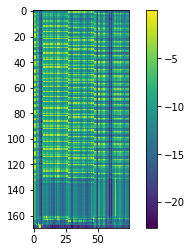

아----------------ᅳ--아--아--아--아--이--이--아--아--아--아--이--이--이--아--아--아--아--아--ᄋ---아---------------------------------------------------ᆻ다--.<eos><eos>
아ᅳ아아아아이이아아아아이이이아아아아아ᄋ았다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


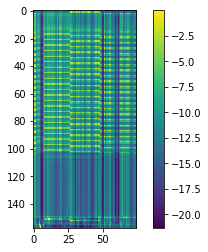

-------------------------------------------------------------------------------------------------------
09-01 11:05:34
Mean Train Loss: 0.05840450818189919
Mean Evaluation Loss: 0.05950232657375206
-------------------------------------------------------------------------------------------------------
09-01 11:05:54
Mean Train Loss: 0.058456671662102805
Mean Evaluation Loss: 0.05808906787750544
-------------------------------------------------------------------------------------------------------
09-01 11:06:14
Mean Train Loss: 0.05821865517037744
Mean Evaluation Loss: 0.05779320774710929
-------------------------------------------------------------------------------------------------------
09-01 11:06:34
Mean Train Loss: 0.05803490873670403
Mean Evaluation Loss: 0.05737412206155587
-------------------------------------------------------------------------------------------------------
09-01 11:06:55
Mean Train Loss: 0.05796628802400685
Mean Evaluation Loss: 0.057222058088615156
--------

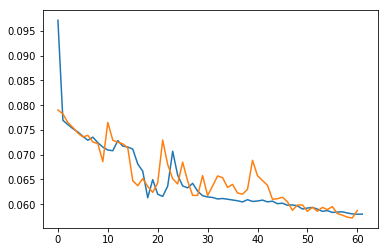

이-----------------이-이--이--이--이--이--이--으--으--ᄋ---이-아--이---이--이---이----이---------------아---아----아---아--아-----으--으-------이--이--이---------------------------ᆻ다--.<eos><eos>
이이이이이이이이으으ᄋ이아이이이이이아아아아아으으이이있다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


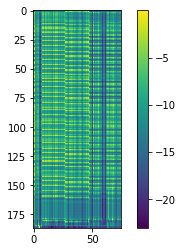

어-----------------ᅳ--으--으--으--으--으--아--아--이--이--이--아--어------아--이--아--아--아--아--아--아--아--아--아---------------------------------니다--.<eos><eos>
어ᅳ으으으으으아아이이이아어아이아아아아아아아아아니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


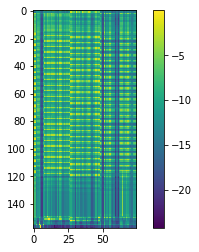

-------------------------------------------------------------------------------------------------------
09-01 11:07:35
Mean Train Loss: 0.059076223676166835
Mean Evaluation Loss: 0.0774890199670081
-------------------------------------------------------------------------------------------------------
09-01 11:07:55
Mean Train Loss: 0.059604776483847585
Mean Evaluation Loss: 0.058820314611497095
-------------------------------------------------------------------------------------------------------
09-01 11:08:16
Mean Train Loss: 0.05875289431699467
Mean Evaluation Loss: 0.059248626441021794
-------------------------------------------------------------------------------------------------------
09-01 11:08:36
Mean Train Loss: 0.0583761532592612
Mean Evaluation Loss: 0.058615943398732856
-------------------------------------------------------------------------------------------------------
09-01 11:08:56
Mean Train Loss: 0.05806431370484322
Mean Evaluation Loss: 0.05819141270838953
-------

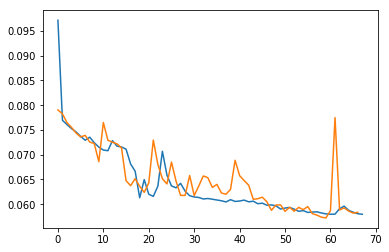

그------------------으--이--이--이--이----이--아----으--아----아--아--아--아---아----아--아--이---이--이---이--이----아--아--이--이---아-------------------------니다--.<eos><eos>
그으이이이이이아으아아아아아아아아이이이이이아아이이아니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


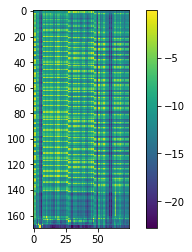

지----------------으--으--으--은-으--이--이--이--아--아--으--으--아--아--이--이--이--이--이--이--이--이--이--있------------------------------------어요--.<eos><eos>
지으으으은으이이이아아으으아아이이이이이이이이이있어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


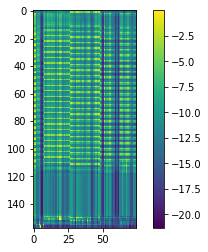

-------------------------------------------------------------------------------------------------------
09-01 11:09:37
Mean Train Loss: 0.05798204242092737
Mean Evaluation Loss: 0.05909915213782633
-------------------------------------------------------------------------------------------------------
09-01 11:09:58
Mean Train Loss: 0.05778394645652308
Mean Evaluation Loss: 0.05844678670337006
-------------------------------------------------------------------------------------------------------
09-01 11:10:18
Mean Train Loss: 0.05760062158446487
Mean Evaluation Loss: 0.058481573618024696
-------------------------------------------------------------------------------------------------------
09-01 11:10:39
Mean Train Loss: 0.0573922862303162
Mean Evaluation Loss: 0.058175842658415744
-------------------------------------------------------------------------------------------------------
09-01 11:10:59
Mean Train Loss: 0.0574786351937508
Mean Evaluation Loss: 0.05800842325724796
----------

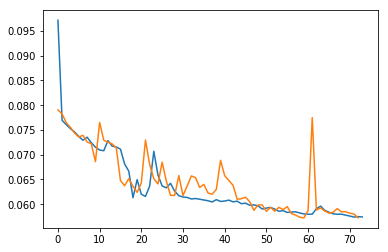

저--------------ᅡ--으-이--이--아---오--오---어--으--이---으--이---이--이---어---어---아--아----아--아--아---아---아--아--아--아--아--아---하----------------------니다-.<eos><eos>
저ᅡ으이이아오오어으이으이이이어어아아아아아아아아아아아아하니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


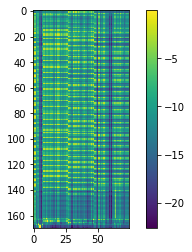

우-----------------ᅡ--은-은-은------------이--아--이--으--으--으--아--아--아--아--아--아--아--이--이--아--아---------------------------------------니다-.<eos><eos>
우ᅡ은은은이아이으으으아아아아아아아이이아아니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


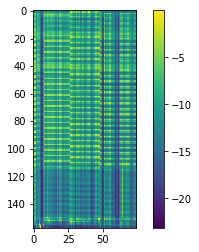

-------------------------------------------------------------------------------------------------------
09-01 11:11:39
Mean Train Loss: 0.0566754615308478
Mean Evaluation Loss: 0.05723931565037887
-------------------------------------------------------------------------------------------------------
09-01 11:11:59
Mean Train Loss: 0.056938303098171515
Mean Evaluation Loss: 0.05664248177093615
-------------------------------------------------------------------------------------------------------
09-01 11:12:19
Mean Train Loss: 0.0571184287130062
Mean Evaluation Loss: 0.05669822113939156
-------------------------------------------------------------------------------------------------------
09-01 11:12:39
Mean Train Loss: 0.056681002601681435
Mean Evaluation Loss: 0.056289965877145694
-------------------------------------------------------------------------------------------------------
09-01 11:13:00
Mean Train Loss: 0.056342097857469686
Mean Evaluation Loss: 0.05592286884043772
--------

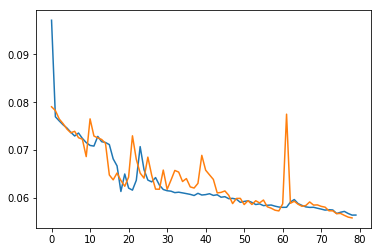

저-------------------으----아--이--이--아--아--아--아--아---아--아--어---ᅥ----오--아---이---아--아---아--이--아--이---이----이---이--ᄉ---------------------------------------------니다-.<eos><eos>
저으아이이아아아아아아아어ᅥ오아이아아아이아이이이이ᄉ니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


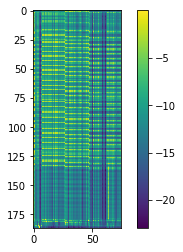

우-------------------은-은-은-으------으--이--이--으--으--으--으--으--어--아--아--아--아--아--이--이--이--이---------------------------------------니다-.<eos><eos>
우은은은으으이이으으으으으어아아아아아이이이이니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


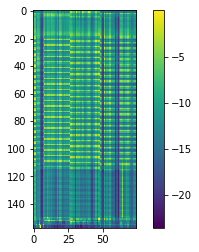

-------------------------------------------------------------------------------------------------------
09-01 11:13:40
Mean Train Loss: 0.056252014264437114
Mean Evaluation Loss: 0.056534031904240646
-------------------------------------------------------------------------------------------------------
09-01 11:14:00
Mean Train Loss: 0.05644111459038933
Mean Evaluation Loss: 0.05636849594933735
-------------------------------------------------------------------------------------------------------
09-01 11:14:20
Mean Train Loss: 0.056390264378833974
Mean Evaluation Loss: 0.05584371452378515
-------------------------------------------------------------------------------------------------------
09-01 11:14:40
Mean Train Loss: 0.05594715119446625
Mean Evaluation Loss: 0.0559198844015929
-------------------------------------------------------------------------------------------------------
09-01 11:15:00
Mean Train Loss: 0.05570385875379293
Mean Evaluation Loss: 0.05558406101982506
--------

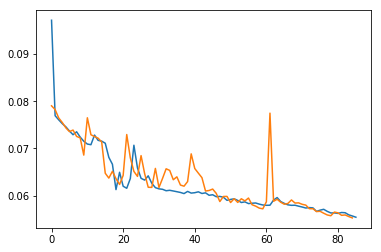

이----------------------------아---이--이----이--아--안-아--아--이--이--이---이--이-아--아---아--아----어----아---이--이--아-----아--아---아--아-----아--하-----------------------니다-.<eos><eos>
이아이이이아안아아이이이이이아아아아어아이이아아아아아아하니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


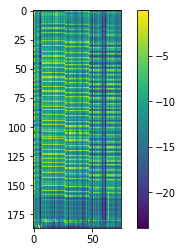

이-----------------는-는------ᅳ--이--으--이--어--아--은-으--으--오--으--아--이--이--이--이--이--이--이----ᆻ----------------------------------------어요-.<eos><eos>
이는는ᅳ이으이어아은으으오으아이이이이이이있어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


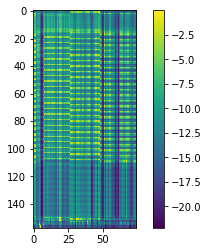

-------------------------------------------------------------------------------------------------------
09-01 11:15:42
Mean Train Loss: 0.05511330325412853
Mean Evaluation Loss: 0.05499658904655748
-------------------------------------------------------------------------------------------------------
09-01 11:16:02
Mean Train Loss: 0.05497593319447536
Mean Evaluation Loss: 0.055329063151190724
-------------------------------------------------------------------------------------------------------
09-01 11:16:22
Mean Train Loss: 0.05476330501270436
Mean Evaluation Loss: 0.05484454081176994
-------------------------------------------------------------------------------------------------------
09-01 11:16:43
Mean Train Loss: 0.056005879922360315
Mean Evaluation Loss: 0.05586920699741457
-------------------------------------------------------------------------------------------------------
09-01 11:17:03
Mean Train Loss: 0.05476550553777178
Mean Evaluation Loss: 0.055639727559844726
-------

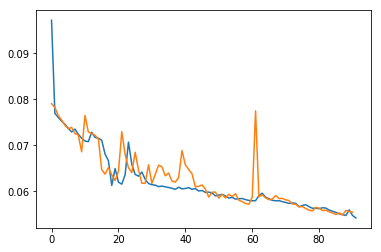

시---------------시----시--시---으--는-은 ----이--아--아---아--아----아---이----이--이---아--아----라--이--아--아--아--아----이--읍------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
시시시시으는은 이아아아아아이이이아아라이아아아아이읍니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


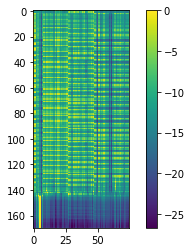

저---------------ᅳ-ᆫ-은-은 는 -ᅳᆫ-오--오--으--이--오--오--오--으----------오--오--으--이--아--아--ᄋ------ᄋᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저ᅳᆫ은은 는 ᅳᆫ오오으이오오오으오오으이아아ᄋ요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


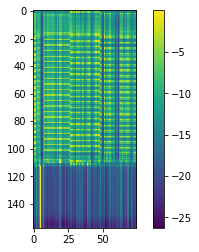

-------------------------------------------------------------------------------------------------------
09-01 11:17:44
Mean Train Loss: 0.053852175670773904
Mean Evaluation Loss: 0.0549040607034833
-------------------------------------------------------------------------------------------------------
09-01 11:18:04
Mean Train Loss: 0.05356488207227017
Mean Evaluation Loss: 0.05481585765907806
-------------------------------------------------------------------------------------------------------
09-01 11:18:24
Mean Train Loss: 0.05311685427384149
Mean Evaluation Loss: 0.05490196644452207
-------------------------------------------------------------------------------------------------------
09-01 11:18:44
Mean Train Loss: 0.05291203722007585
Mean Evaluation Loss: 0.05495863943649794
-------------------------------------------------------------------------------------------------------
09-01 11:19:04
Mean Train Loss: 0.05411338294889814
Mean Evaluation Loss: 0.055494311479984036
---------

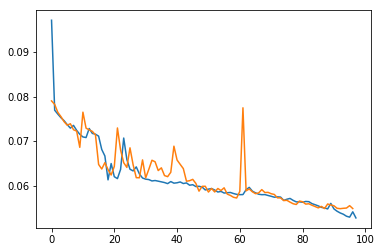

우ᄅ----------느--이---으- 자----오--이--이--아--아----자---사----시--아--이--으---아---나--오--이--이--이--이-이---아--아---시----니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᄅ느이으 자오이이아아자사시아이으아나오이이이이이아아시니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


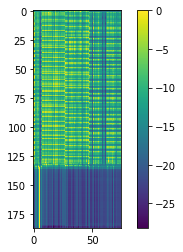

이----------------------은 은 --ᆫ --ᆫ-은 으- 으- 으--아--으--으--으--은----------오--아--으--으--으--으--아--아--아------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이은 은 ᆫ ᆫ은 으 으 으아으으으은오아으으으으아아아아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


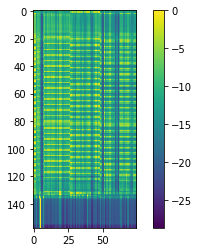

-------------------------------------------------------------------------------------------------------
09-01 11:19:45
Mean Train Loss: 0.05230092983833628
Mean Evaluation Loss: 0.05438629350053077
-------------------------------------------------------------------------------------------------------
09-01 11:20:05
Mean Train Loss: 0.05192597273687032
Mean Evaluation Loss: 0.05381331341234867
-------------------------------------------------------------------------------------------------------
09-01 11:20:25
Mean Train Loss: 0.05199598099096702
Mean Evaluation Loss: 0.05499459813411566
-------------------------------------------------------------------------------------------------------
09-01 11:20:46
Mean Train Loss: 0.05165302718712698
Mean Evaluation Loss: 0.05361435628003468
-------------------------------------------------------------------------------------------------------
09-01 11:21:06
Mean Train Loss: 0.05169011625800284
Mean Evaluation Loss: 0.054670557848383226
---------

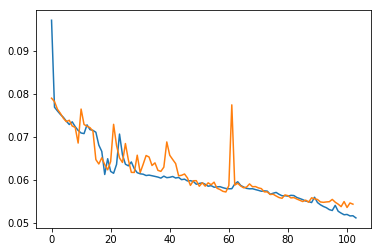

그------------사----시--으--으----시--애-난---고--구--어----어--어--안---으--아--으--아--아--이--이- 이--이----이----어-----시--------ᆸ-니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그사시으으시애난고구어어어안으아으아아이이 이이이어십니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


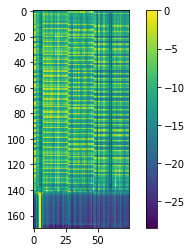

어-----------은 -ᅳᆫ -은 -ᅳ--------ᆫ 은 아- 지--사- 안 안 은 이- 닌 은 --ᆫ 안 어- 안 아- 아--아---------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어은 ᅳᆫ 은 ᅳᆫ 은 아 지사 안 안 은 이 닌 은 ᆫ 안 어 안 아 아아아요.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


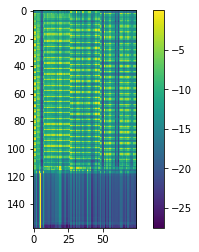

-------------------------------------------------------------------------------------------------------
09-01 11:21:46
Mean Train Loss: 0.05074100857080796
Mean Evaluation Loss: 0.05776396418189946
-------------------------------------------------------------------------------------------------------
09-01 11:22:07
Mean Train Loss: 0.050653403971660585
Mean Evaluation Loss: 0.054094243882498366
-------------------------------------------------------------------------------------------------------
09-01 11:22:28
Mean Train Loss: 0.05036406861271713
Mean Evaluation Loss: 0.05437772593166447
-------------------------------------------------------------------------------------------------------
09-01 11:22:48
Mean Train Loss: 0.049911873282172364
Mean Evaluation Loss: 0.05439169010913432
-------------------------------------------------------------------------------------------------------
09-01 11:23:08
Mean Train Loss: 0.04959081566620813
Mean Evaluation Loss: 0.05378742122868598
-------

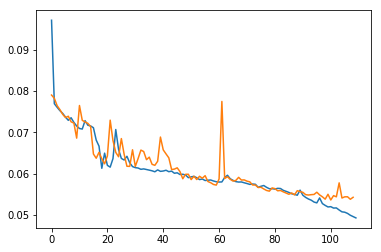

하---------------느--으--은 -서--아--오---아---은--아----아--오- -그- 지--시---지--어----서- --서--아--으--으--오----지--아--아----ᆸ-------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하느으은 서아오아은아아오 그 지시지어서 서아으으오지아압니다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


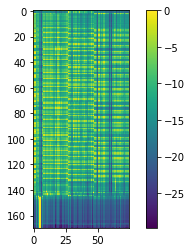

우ᄅ------------------ᅳᆫ 인 잔-은 -ᅳᆫ 은 은 즌 진 시- 진-이--세- ----슨 지--시--은 아- 이--이- 이- 이--이--------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우른 인 잔은 ᅳᆫ 은 은 즌 진 시 진이세 슨 지시은 아 이이 이 이이니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


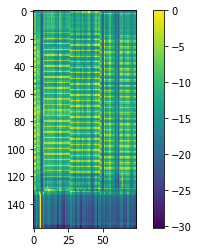

-------------------------------------------------------------------------------------------------------
09-01 11:23:48
Mean Train Loss: 0.04889994347985431
Mean Evaluation Loss: 0.05502703223943718
-------------------------------------------------------------------------------------------------------
09-01 11:24:10
Mean Train Loss: 0.0485707280967763
Mean Evaluation Loss: 0.05527677947486445
-------------------------------------------------------------------------------------------------------
09-01 11:24:30
Mean Train Loss: 0.04816437117958358
Mean Evaluation Loss: 0.05588247302555702
-------------------------------------------------------------------------------------------------------
09-01 11:24:50
Mean Train Loss: 0.04792590129776321
Mean Evaluation Loss: 0.05547118310943525
-------------------------------------------------------------------------------------------------------
09-01 11:25:10
Mean Train Loss: 0.047340681694277166
Mean Evaluation Loss: 0.05427909946228113
----------

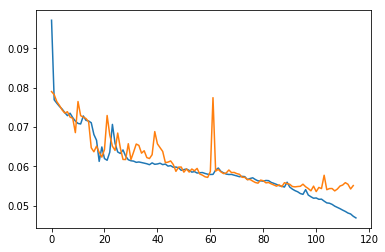

이 --------------------아--은 으----사--아- 으- --주---사--서--시--시--사--드----으--아--이---여- -가--으--지----글--으--아---가----아----이-------ᆸ---니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 아은 으사아 으 주사서시시사드으아이여 가으지글으아가아입니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


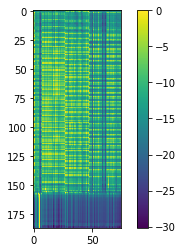

여-----------------ᆫ--ᅡᆫ 은 안 은 인 인-은 언 만-이--으--은 ----은 은 언-아- 오--------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
연ᅡᆫ 은 안 은 인 인은 언 만이으은 은 은 언아 옸다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


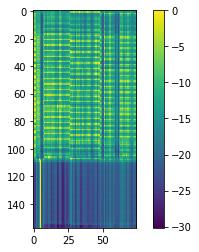

-------------------------------------------------------------------------------------------------------
09-01 11:25:50
Mean Train Loss: 0.04659816668865527
Mean Evaluation Loss: 0.059331135435360303
-------------------------------------------------------------------------------------------------------
09-01 11:26:10
Mean Train Loss: 0.04631161500283547
Mean Evaluation Loss: 0.05567285134336831
-------------------------------------------------------------------------------------------------------
09-01 11:26:30
Mean Train Loss: 0.0459594658509498
Mean Evaluation Loss: 0.054864386582591906
-------------------------------------------------------------------------------------------------------
09-01 11:26:50
Mean Train Loss: 0.04538380334552386
Mean Evaluation Loss: 0.05460543526027471
-------------------------------------------------------------------------------------------------------
09-01 11:27:10
Mean Train Loss: 0.045059852958985284
Mean Evaluation Loss: 0.05606520693472565
--------

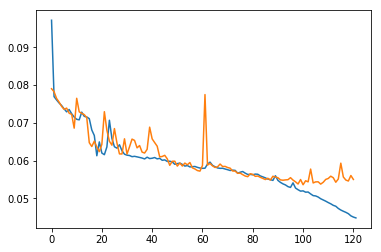

다---------------시---시---사---시---아- 오-고----아---고---서--스---아---서--자-을-다- 가--을 자--아---거---으--이---있----습-----니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
다시시사시아 오고아고서스아서자을다 가을 자아거으이있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


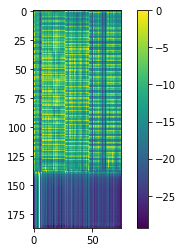

이 ---------------ᆫ-는--ᅳᆫ -----ᅡᆫ-잔-은 선-안-안-는 --ᆫ 전-언-은 안-진 인-이--이--이----ᆻ---ᆻ----어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 ᆫ는ᅳᆫ ᅡᆫ잔은 선안안는 ᆫ 전언은 안진 인이이있ᆻ어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


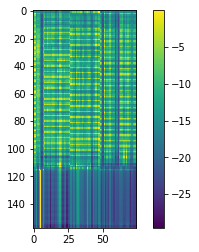

-------------------------------------------------------------------------------------------------------
09-01 11:27:52
Mean Train Loss: 0.04443025660820699
Mean Evaluation Loss: 0.05516309187144029
-------------------------------------------------------------------------------------------------------
09-01 11:28:12
Mean Train Loss: 0.043839013064467414
Mean Evaluation Loss: 0.05636470563448038
-------------------------------------------------------------------------------------------------------
09-01 11:28:32
Mean Train Loss: 0.04364647187796193
Mean Evaluation Loss: 0.05395269087950026
-------------------------------------------------------------------------------------------------------
09-01 11:28:52
Mean Train Loss: 0.04346873317194652
Mean Evaluation Loss: 0.05602511692310814
-------------------------------------------------------------------------------------------------------
09-01 11:29:12
Mean Train Loss: 0.0430310808899553
Mean Evaluation Loss: 0.05555852088669753
----------

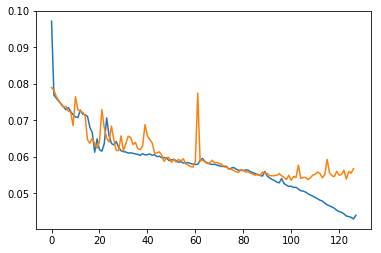

저--------지--지--어----지--우--으- 은 아---자--사--자----은--으- 이--지--사-----오---진-은 마---가---은 아-이--이--어----이--------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저지지어지우으 은 아자사자은으 이지사오진은 마가은 아이이어이어요.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


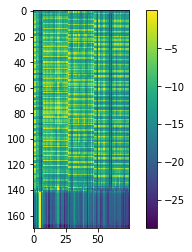

이--------------ᅵ---ᅳ---느-----------인- 문-인-이---안-안--인--은 -----중--ᅥ-ᆫ-자--은-아--아-----이- -------------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᅵᅳ느인 문인이안안인은 중ᅥᆫ자은아아이 아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


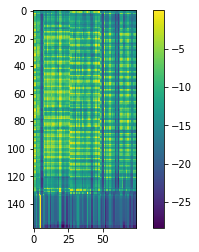

-------------------------------------------------------------------------------------------------------
09-01 11:29:54
Mean Train Loss: 0.04750023766064742
Mean Evaluation Loss: 0.053422129833016765
-------------------------------------------------------------------------------------------------------
09-01 11:30:14
Mean Train Loss: 0.04418541824962766
Mean Evaluation Loss: 0.054591248527405746
-------------------------------------------------------------------------------------------------------
09-01 11:30:34
Mean Train Loss: 0.04290809743903655
Mean Evaluation Loss: 0.05631692999168414
-------------------------------------------------------------------------------------------------------
09-01 11:30:54
Mean Train Loss: 0.042057422107830825
Mean Evaluation Loss: 0.05771632683647879
-------------------------------------------------------------------------------------------------------
09-01 11:31:15
Mean Train Loss: 0.041891169455822594
Mean Evaluation Loss: 0.05525680877786986
------

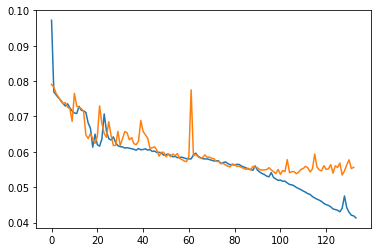

저------------는-는 아---진---이---여--가--서- 수--으--오----하--드--이-이ᅵ 아---마--이--을-느--ᅳ- 아--아--이- 시--이- 어---이---------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는는 아진이여가서 수으오하드이이 아마이을느ᅳ 아아이 시이 어이아요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


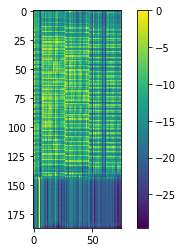

한-----------------군-은 구--으---ᅳᆫ---------신-은-은-닌-ᄀ-- 만-은 이--은 안-은-거----------------요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
한군은 구으ᅳᆫ신은은닌ᄀ 만은 이은 안은거요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


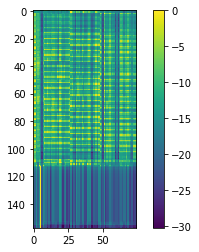

-------------------------------------------------------------------------------------------------------
09-01 11:31:55
Mean Train Loss: 0.04088396952008817
Mean Evaluation Loss: 0.05573317009696557
-------------------------------------------------------------------------------------------------------
09-01 11:32:15
Mean Train Loss: 0.04050996254143131
Mean Evaluation Loss: 0.05659428672006438
-------------------------------------------------------------------------------------------------------
09-01 11:32:35
Mean Train Loss: 0.04014924255342267
Mean Evaluation Loss: 0.05824008937807751
-------------------------------------------------------------------------------------------------------
09-01 11:32:55
Mean Train Loss: 0.03971892740108743
Mean Evaluation Loss: 0.0579941737492928
-------------------------------------------------------------------------------------------------------
09-01 11:33:16
Mean Train Loss: 0.03941474518063114
Mean Evaluation Loss: 0.05820794730694527
-----------

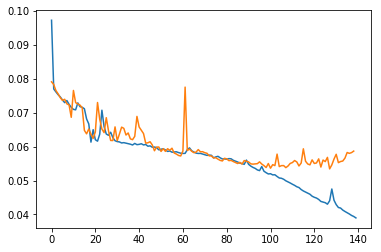

나----------------는-는 이--ᅡ-아--- 자--지--가--거--조---- 고--도--거---은  수-ᄉ--한-ᅳ-은----이  이--구--곡ᄌᄌ--기---고--지---아- --하-----------ᆫ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
나는는 이ᅡ아 자지가거조 고도거은 수ᄉ한ᅳ은이 이구곡ᄌ기고지아 한다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


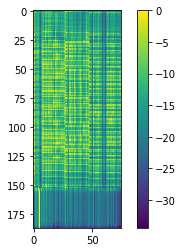

이-------------------는-는 --------시--은 수- 한 한-은---- 상-궁-는-은 선-인 은 이- 어----ᆻ-----------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이는는 시은 수 한 한은 상궁는은 선인 은 이 었어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


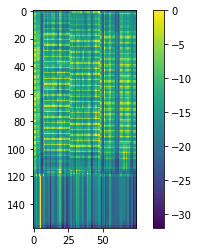

-------------------------------------------------------------------------------------------------------
09-01 11:33:56
Mean Train Loss: 0.03878532314556708
Mean Evaluation Loss: 0.057129691623551686
-------------------------------------------------------------------------------------------------------
09-01 11:34:16
Mean Train Loss: 0.03847993665326603
Mean Evaluation Loss: 0.05603043429138876
-------------------------------------------------------------------------------------------------------
09-01 11:34:36
Mean Train Loss: 0.038134496754849576
Mean Evaluation Loss: 0.057481237752143144
-------------------------------------------------------------------------------------------------------
09-01 11:34:58
Mean Train Loss: 0.03790556634447407
Mean Evaluation Loss: 0.05784180229272671
-------------------------------------------------------------------------------------------------------
09-01 11:35:17
Mean Train Loss: 0.037545636734408125
Mean Evaluation Loss: 0.05795090460411477
------

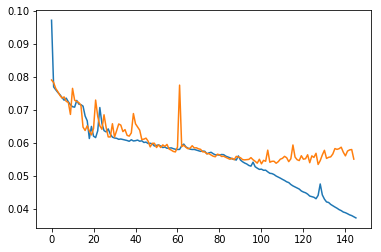

제-------가--그- 고--고--데--지--지--일-아----래--는  일리ᅵ-를 더----을--게------ 저--은 종-모---안 이-이--지--아---아--------ᆻ--------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
제가그 고고데지지일아래는 일리를 더을게 저은 종모안 이이지아았어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


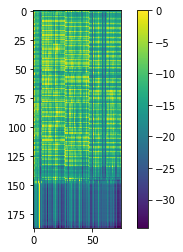

서-----------------ᆫ 는-지--은 성-안-흔 은 진-먼-은 군-므, --- 고--근 신 인-닌 하---------------해요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
선 는지은 성안흔 은 진먼은 군므,  고근 신 인닌 하해요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


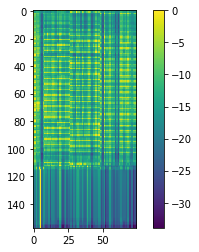

-------------------------------------------------------------------------------------------------------
09-01 11:35:58
Mean Train Loss: 0.037017996698732895
Mean Evaluation Loss: 0.0570209934073576
-------------------------------------------------------------------------------------------------------
09-01 11:36:18
Mean Train Loss: 0.03674078371358133
Mean Evaluation Loss: 0.05556852703579688
-------------------------------------------------------------------------------------------------------
09-01 11:36:39
Mean Train Loss: 0.036614044562808465
Mean Evaluation Loss: 0.05571309118666853
-------------------------------------------------------------------------------------------------------
09-01 11:36:59
Mean Train Loss: 0.03618297047403803
Mean Evaluation Loss: 0.06193522781621904
-------------------------------------------------------------------------------------------------------
09-01 11:37:19
Mean Train Loss: 0.03615435528024859
Mean Evaluation Loss: 0.06122950685292513
---------

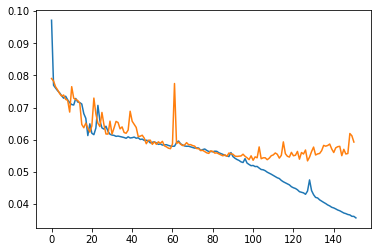

제-----가- 그- 거---으--대- 이--이--니--다--라--는  이--릴-- 딜-어--이-----겐 ------저--족-고---만 -니--이--ᅵ- 아--아----------ᆻ-------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
제가 그 거으대 이이니다라는 이릴 딜어이겐 저족고만 니이ᅵ 아았어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


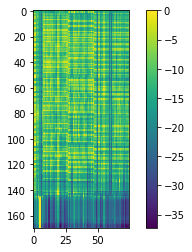

이----------------치--은-는-은 인-ᄋ-- 서- 운-은-은 ----하--------- 긍-은 장 운-운-인 오----------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이치은는은 인ᄋ 서 운은은 하 긍은 장 운운인 오다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


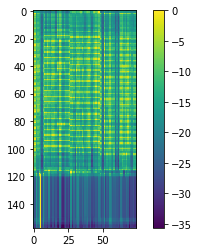

-------------------------------------------------------------------------------------------------------
09-01 11:38:00
Mean Train Loss: 0.03539410283457511
Mean Evaluation Loss: 0.060561314073022045
-------------------------------------------------------------------------------------------------------
09-01 11:38:20
Mean Train Loss: 0.03502845141632557
Mean Evaluation Loss: 0.059251270766106666
-------------------------------------------------------------------------------------------------------
09-01 11:38:40
Mean Train Loss: 0.03482222403898137
Mean Evaluation Loss: 0.06004264578770712
-------------------------------------------------------------------------------------------------------
09-01 11:39:00
Mean Train Loss: 0.034585115526435145
Mean Evaluation Loss: 0.05697236098017381
-------------------------------------------------------------------------------------------------------
09-01 11:39:20
Mean Train Loss: 0.034244411371437945
Mean Evaluation Loss: 0.05566498562203237
------

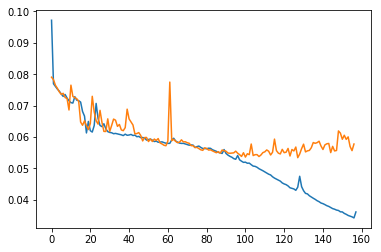

장-------------닌--이- 지--지--에--한--는-는-버-이-이  치--는 가--다. ᄌ-----자--이--는 -난---지  복-평--정---인 장-드----일--시-------ᅵ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
장닌이 지지에한는는버이이 치는 가다. ᄌ자이는 난지 복평정인 장드일시ᅵ다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


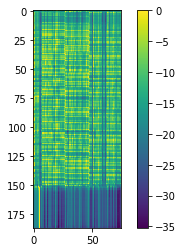

이 ----------------시--믄 운-는 은-어- 언 문-흔-은 ----하---ᅵ----  궁--ᅳ ᄌ-ᆫ 잉-문 인 어----ᆻ---------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 시믄 운는 은어 언 문흔은 하ᅵ 궁ᅳ ᄌᆫ 잉문 인 었다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


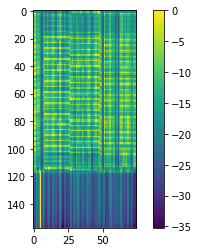

-------------------------------------------------------------------------------------------------------
09-01 11:40:01
Mean Train Loss: 0.034647450100753145
Mean Evaluation Loss: 0.05533568529654257
-------------------------------------------------------------------------------------------------------
09-01 11:40:21
Mean Train Loss: 0.03420427632586151
Mean Evaluation Loss: 0.055307284526739414
-------------------------------------------------------------------------------------------------------
09-01 11:40:41
Mean Train Loss: 0.03444662093134442
Mean Evaluation Loss: 0.05642030865688571
-------------------------------------------------------------------------------------------------------
09-01 11:41:01
Mean Train Loss: 0.03348958279430652
Mean Evaluation Loss: 0.05867278417890003
-------------------------------------------------------------------------------------------------------
09-01 11:41:21
Mean Train Loss: 0.03320886779559438
Mean Evaluation Loss: 0.05765400095156935
--------

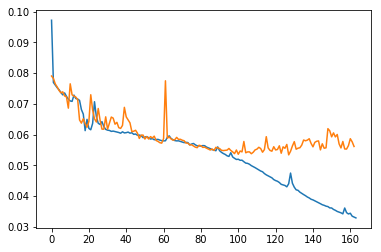

나-------------------ᄂ---- 느--사---가-ᅡ  자----이  가--족-존 모---ᅩ-버--으-- 소--수-라--는 것-이  기--보--도--정-이--로- --자--가--하--------------ᆫ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
나ᄂ 느사가ᅡ 자이 가족존 모ᅩ버으 소수라는 것이 기보도정이로 자가한다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


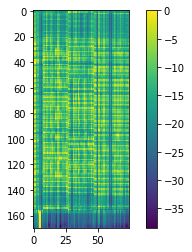

우------------------ᅵ- 간-이--있-는 기--군-엔 상-굼-이----ᆫ 이--영- 은-숭-잉 형-욱-개--구-----------------ᆫ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᅵ 간이있는 기군엔 상굼인 이영 은숭잉 형욱개군다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


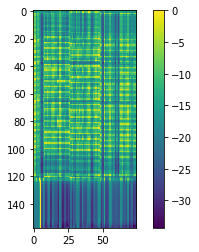

-------------------------------------------------------------------------------------------------------
09-01 11:42:03
Mean Train Loss: 0.03305045281473742
Mean Evaluation Loss: 0.056171629346421836
-------------------------------------------------------------------------------------------------------
09-01 11:42:23
Mean Train Loss: 0.0327391012964337
Mean Evaluation Loss: 0.058720419694256155
-------------------------------------------------------------------------------------------------------
09-01 11:42:43
Mean Train Loss: 0.03248943704121497
Mean Evaluation Loss: 0.057939575015339674
-------------------------------------------------------------------------------------------------------
09-01 11:43:03
Mean Train Loss: 0.03214351234749021
Mean Evaluation Loss: 0.05594124700041737
-------------------------------------------------------------------------------------------------------
09-01 11:43:23
Mean Train Loss: 0.03209245002156301
Mean Evaluation Loss: 0.05920986230392229
--------

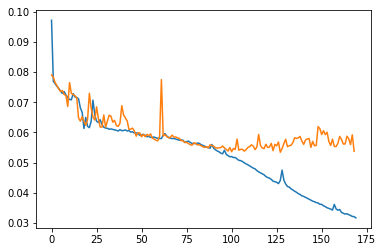

우ᄅ-----ᅵ--는  천--거---이  구-신 년--애  ᅢ사-ᅡ를-서--시- ᅥ 타--지---내  늖-는ᄋ- 도---인-들-ᆯ 지--어--하---았--습----니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리는 천거이 구신 년애 ᅢ사ᅡ를서시 ᅥ 타지내 늖는ᄋ 도인들ᆯ 지어하았습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


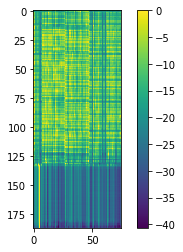

욤----------ᅳᆷ-음-은 이--느--무--는 ᄋ---한-운 은 군-은 고--구--아--구----  성-운 움 우----------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
욤ᅳᆷ음은 이느무는 ᄋ한운 은 군은 고구아구 성운 움 우어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


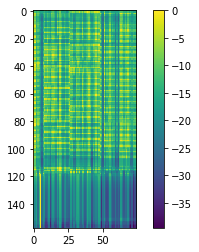

-------------------------------------------------------------------------------------------------------
09-01 11:44:04
Mean Train Loss: 0.03167656755179635
Mean Evaluation Loss: 0.05550760251732382
-------------------------------------------------------------------------------------------------------
09-01 11:44:24
Mean Train Loss: 0.031320792009666434
Mean Evaluation Loss: 0.05651872324112946
-------------------------------------------------------------------------------------------------------
09-01 11:44:44
Mean Train Loss: 0.030962078725757916
Mean Evaluation Loss: 0.062015477096052936
-------------------------------------------------------------------------------------------------------
09-01 11:45:04
Mean Train Loss: 0.030908440931970538
Mean Evaluation Loss: 0.05562543910700389
-------------------------------------------------------------------------------------------------------
09-01 11:45:24
Mean Train Loss: 0.030831781364078062
Mean Evaluation Loss: 0.05422589655406461
-----

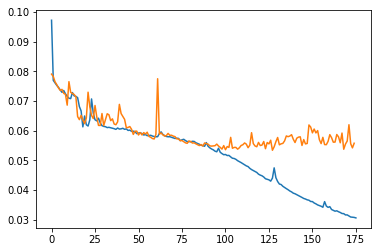

그------------년- 자--시-이ᅴ 지ᄌ--닌--은 -여ᄋ--에  며며---어  부----를 수-ᄒ하-는 -대-ᅳᆫ 아--무- 고--시---이  --없-었-------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그년 자시이ᅴ 지ᄌ닌은 여ᄋ에 며며어 부를 수하는 대ᅳᆫ 아무 고시이 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


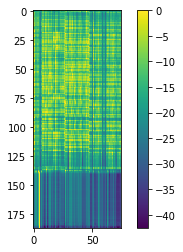

저------------------는 궁-앙-이----  안-영-인 영-장-을 댕-을 흥-우----- ----언 야--아----ᆻ---------------ᅡ아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 궁앙이 안영인 영장을 댕을 흥우 언 야았ᅡ아.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


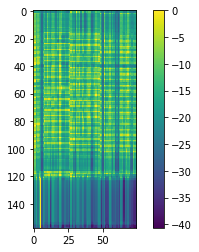

-------------------------------------------------------------------------------------------------------
09-01 11:46:05
Mean Train Loss: 0.03074673473828439
Mean Evaluation Loss: 0.05672905374197639
-------------------------------------------------------------------------------------------------------
09-01 11:46:25
Mean Train Loss: 0.03049221992496307
Mean Evaluation Loss: 0.05481020078494734
-------------------------------------------------------------------------------------------------------
09-01 11:46:45
Mean Train Loss: 0.03033224666588911
Mean Evaluation Loss: 0.04980572956857848
-------------------------------------------------------------------------------------------------------
09-01 11:47:05
Mean Train Loss: 0.030337171763072063
Mean Evaluation Loss: 0.052476568398006324
-------------------------------------------------------------------------------------------------------
09-01 11:47:25
Mean Train Loss: 0.030890293986606986
Mean Evaluation Loss: 0.051675345496510636
------

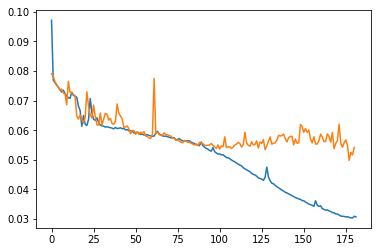

우ᄅ------------------ᅵ-----는 무--구--이  글-러-자다--의ᅦ ᄀ거-기ᅵ--을 보ᄒ하-하--기 -위-----  개---소--개-서  시-서--을 다---할--골--이---ᆸᆸ---------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리는 무구이 글러자다의ᅦ 거기을 보하하기 위 개소개서 시서을 다할골입니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


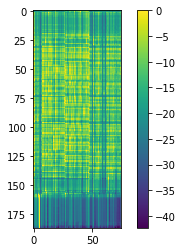

므-----------------숭-은 이--깅 뭉-메-  -ᄒᄒ항 궁 운 둥-은 궁-웅-하--오-  -  성 운 웁-시----ᆻ---------ᄋᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
므숭은 이깅 뭉메 항 궁 운 둥은 궁웅하오  성 운 웁싰요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


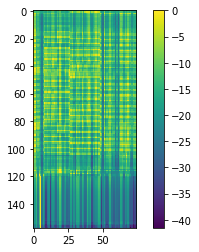

-------------------------------------------------------------------------------------------------------
09-01 11:48:06
Mean Train Loss: 0.03085781587568658
Mean Evaluation Loss: 0.04690007289342995
-------------------------------------------------------------------------------------------------------
09-01 11:48:26
Mean Train Loss: 0.03227823772178916
Mean Evaluation Loss: 0.054067668431930435
-------------------------------------------------------------------------------------------------------
09-01 11:48:45
Mean Train Loss: 0.033687909154445084
Mean Evaluation Loss: 0.045813253209590454
-------------------------------------------------------------------------------------------------------
09-01 11:49:07
Mean Train Loss: 0.03171112876312213
Mean Evaluation Loss: 0.04711906482219362
-------------------------------------------------------------------------------------------------------
09-01 11:49:27
Mean Train Loss: 0.032992462721987845
Mean Evaluation Loss: 0.04803846245524976
------

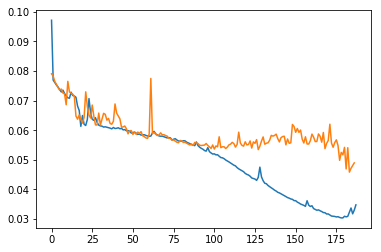

사-----------라--듬-ᅳᆯᅳᆫ 얼리-이는 사ᅡᅡᆷ을ᆯ도ᅩᆯ을 ᄄ떼   소--ᅩᆷ-ᅳᆯ 오-옿하-에  ᅡᅡᆫ-가- ᄋᄋ--ᅳ-하ᅡ-이--되----------ᆸ---니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
사라듬ᅳᆯᅳᆫ 얼리이는 삼을돌을 떼 소ᅩᆷᅳᆯ 오옿하에 ᅡᆫ가 으하이됩니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


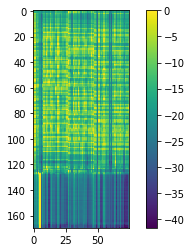

인-------------중-이---ᆫᆫ 흐---ᅮᆼ-가--항-숭-숭이ᅵ  궁-기--가- 그--형-한 장-ᅳᆫ--ᅭᅮᆼ-문 마---------------나요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
인중인 흐ᅮᆼ가항숭숭이 궁기가 그형한 장ᅳᆫᅭᅮᆼ문 마나요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


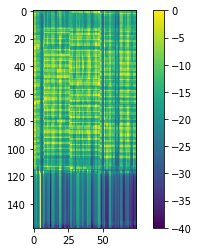

-------------------------------------------------------------------------------------------------------
09-01 11:50:07
Mean Train Loss: 0.033335422263216244
Mean Evaluation Loss: 0.051808945607115096
-------------------------------------------------------------------------------------------------------
09-01 11:50:27
Mean Train Loss: 0.03424992176853288
Mean Evaluation Loss: 0.05394916447365046
-------------------------------------------------------------------------------------------------------
09-01 11:50:49
Mean Train Loss: 0.032030811259510066
Mean Evaluation Loss: 0.04226773333562576
-------------------------------------------------------------------------------------------------------
09-01 11:51:08
Mean Train Loss: 0.035032155538089214
Mean Evaluation Loss: 0.04675359156104083
-------------------------------------------------------------------------------------------------------
09-01 11:51:28
Mean Train Loss: 0.03425802292682238
Mean Evaluation Loss: 0.0430093658666162
-------

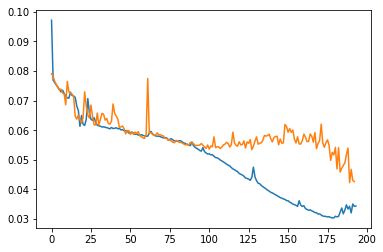

시-----------------------사--숙북-브--대-   개---ᆯ일를 사-ᅡᅡᆯᅡ  자 길레  ᅦᆯ-정에  스ᅳᅳ 않이를들-들-대-  이 영-안----------ᆸᆸ-------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
시사숙북브대 갤일를 사ᅡᆯᅡ 자 길레 ᅦᆯ정에 스 않이를들들대 이 영안ᆸ니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


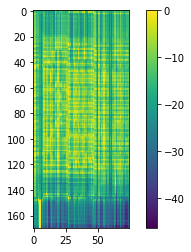

이 --------------마-이-느ᅳᆫ   하--싱임은 숭-망-강-은 자---ᅮ---피-이-ᄋᆫ 성심입 기  이ᄋᄋᄋ어---ᆻᆻᆻ---------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 마이는 하싱임은 숭망강은 자ᅮ피이ᄋᆫ 성심입 기 이었어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


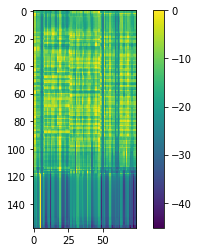

-------------------------------------------------------------------------------------------------------
09-01 11:52:09
Mean Train Loss: 0.032947844640949984
Mean Evaluation Loss: 0.04229949029922824
-------------------------------------------------------------------------------------------------------
09-01 11:52:29
Mean Train Loss: 0.031147437027350715
Mean Evaluation Loss: 0.04446233784771714
-------------------------------------------------------------------------------------------------------
09-01 11:52:49
Mean Train Loss: 0.03127003121563906
Mean Evaluation Loss: 0.042563524675743904
-------------------------------------------------------------------------------------------------------
09-01 11:53:09
Mean Train Loss: 0.032061101866098236
Mean Evaluation Loss: 0.04332412604713213
-------------------------------------------------------------------------------------------------------
09-01 11:53:29
Mean Train Loss: 0.031549525134542865
Mean Evaluation Loss: 0.04195275049723835
-----

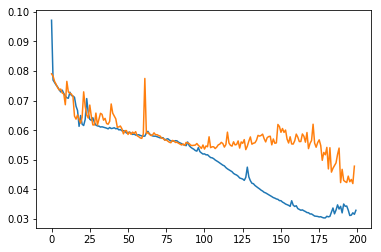

그------------ᄅ른 시-간이- 닥 직-드-면  그--로--ᅡ한 경마-한 굴ᅮ-자-들을 사핼 길-ᅵᆯ-이-  개-ᄉ--ᅥᆫ-들ᄀ고  이----ᆸ------------이다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그른 시간이 닥 직드면 그로ᅡ한 경마한 굴ᅮ자들을 사핼 길ᅵᆯ이 개선들고 입이다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


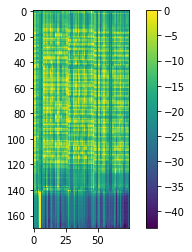

이 ----------------지-느-는ᆫᆫ    -장기  무-뭄-ᅵᅵ 이 아-으--ᅵ--ᅵᆫ 은ᆫ    ᄌ중-굥-하- 자 은 가- 인  ᄋ------------------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 지느는 장기 무뭄ᅵ 이 아으ᅵᅵᆫ 은 중굥하 자 은 가 인 ᄋ아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


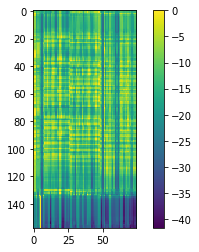

-------------------------------------------------------------------------------------------------------
09-01 11:54:10
Mean Train Loss: 0.030683793313780815
Mean Evaluation Loss: 0.03774576690906456
-------------------------------------------------------------------------------------------------------
09-01 11:54:30
Mean Train Loss: 0.033582526269697696
Mean Evaluation Loss: 0.04057063347721179
-------------------------------------------------------------------------------------------------------
09-01 11:54:50
Mean Train Loss: 0.030469292568149387
Mean Evaluation Loss: 0.04344992472411956
-------------------------------------------------------------------------------------------------------
09-01 11:55:10
Mean Train Loss: 0.029617045938266754
Mean Evaluation Loss: 0.04439508780497944
-------------------------------------------------------------------------------------------------------
09-01 11:55:30
Mean Train Loss: 0.03201918067180359
Mean Evaluation Loss: 0.04641135623834706
------

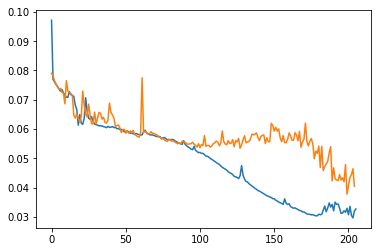

뎡--------------------시-산 사ᄉ신ᅳᆫ 언뭉바-아ᅡᄀ-고ᅩ    뎡ᄌ지-의  거-신-자--은   다-른 사-라-꺼  고-앵하- 수  있ᄉ스---ᆸᆸ-------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
뎡시산 사신ᅳᆫ 언뭉바아ᄀ고 뎡지의 거신자은 다른 사라꺼 고앵하 수 있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


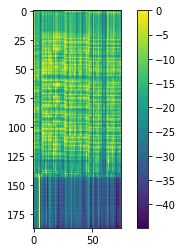

오---------------------는 장-나-는 음ᄋᄋᆫᆫ 종짐으  ᄉ슸-헤-ᄉ서ᅥ   ᄉᄉ--은 층엔끈는 것-십믄 이 ᄉᄉᆼᆻ--------ᆸᆸ--------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
오는 장나는 음ᄋᆫ 종짐으 슸헤서 ᄉ은 층엔끈는 것십믄 이 ᄉᆼᆻᆸ니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


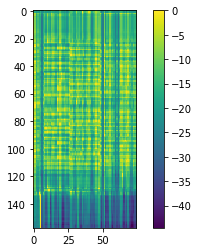

-------------------------------------------------------------------------------------------------------
09-01 11:56:12
Mean Train Loss: 0.031063013637131192
Mean Evaluation Loss: 0.04023576974491228
-------------------------------------------------------------------------------------------------------
09-01 11:56:32
Mean Train Loss: 0.031486382303303556
Mean Evaluation Loss: 0.03980761175507257
-------------------------------------------------------------------------------------------------------
09-01 11:56:52
Mean Train Loss: 0.029804549698046207
Mean Evaluation Loss: 0.03985895520270193
-------------------------------------------------------------------------------------------------------
09-01 11:57:12
Mean Train Loss: 0.029276376741907927
Mean Evaluation Loss: 0.04697288307973696
-------------------------------------------------------------------------------------------------------
09-01 11:57:32
Mean Train Loss: 0.029198046458820442
Mean Evaluation Loss: 0.04296285110812425
-----

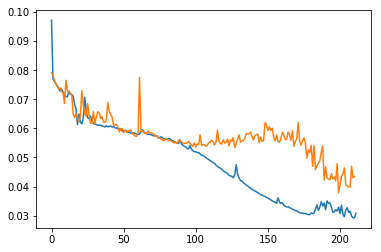

이 -------------------------얀ᄋᄋᆯ 도-새--사--에-     봉-상-에-서  기숙-자-들이  파-이엔 대ᄅ로-    혀--자  지-안-들 과- ᄒ하-옥-가-------ᆸᆸ---------니다..<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 얀ᄋᆯ 도새사에 봉상에서 기숙자들이 파이엔 대로 혀자 지안들 과 하옥갑니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


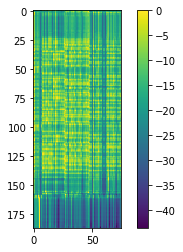

중------------ᄉ소-문-진-안-    순-중-이-이 기ᅳᅳᆫᆫᅳᅳᆫ    시ᅵ-앙 안은 성 ᄋᄋ--는근-하- 시-----ᆸᆸᆸ-----------니다..<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
중소문진안 순중이이 기ᅳᆫᅳᆫ 시앙 안은 성 ᄋ는근하 십니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


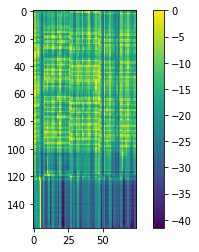

-------------------------------------------------------------------------------------------------------
09-01 11:58:13
Mean Train Loss: 0.03334274498782899
Mean Evaluation Loss: 0.03807386039153025
-------------------------------------------------------------------------------------------------------
09-01 11:58:34
Mean Train Loss: 0.03539218183941142
Mean Evaluation Loss: 0.04450341707653082
-------------------------------------------------------------------------------------------------------
09-01 11:58:54
Mean Train Loss: 0.033834366698943
Mean Evaluation Loss: 0.03712918038390685
-------------------------------------------------------------------------------------------------------
09-01 11:59:13
Mean Train Loss: 0.03130035069999106
Mean Evaluation Loss: 0.03716681616601307
-------------------------------------------------------------------------------------------------------
09-01 11:59:34
Mean Train Loss: 0.03177391357345736
Mean Evaluation Loss: 0.0399251865200337
-------------

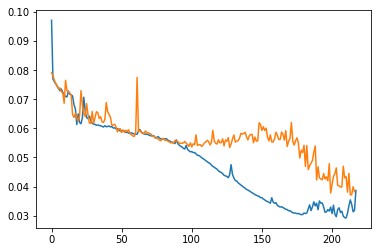

이 -----------이-ᄉ시 이  시 에  사리-지-ᆻ자-은  이--ᅵᆯ  ᅡ-이-슸자-에  슬ᄀ애ᄋ이-라-     ------ 다ᅡ-ᄉ시 자-이- 아-므ᅳᆫ 다-이-가-   -------이-기--ᅳ--------------는<eos><eos><eos><eos><eos><eos>
이 이시 이 시 에 사리짔자은 이ᅵᆯ ᅡ이슸자에 슬ᄀ애이라  다시 자이 아믄 다이가 이기ᅳ는<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


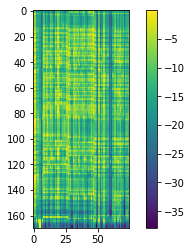

그 -------------여ᅧ-송-정-ᅡ-은     여-성의  상 ᄌ전 지-을 모--기-는 데-  긍이  이-ᄋ---ᄋ--아---ᆻ---------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그 여송정ᅡ은 여성의 상 전 지을 모기는 데 긍이 이ᄋᄋ았다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


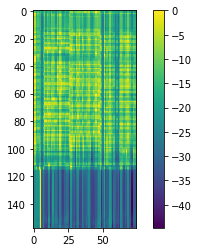

-------------------------------------------------------------------------------------------------------
09-01 12:00:14
Mean Train Loss: 0.03211194070317401
Mean Evaluation Loss: 0.040008375308167796
-------------------------------------------------------------------------------------------------------
09-01 12:00:34
Mean Train Loss: 0.031065295383155896
Mean Evaluation Loss: 0.041659745142865696
-------------------------------------------------------------------------------------------------------
09-01 12:00:54
Mean Train Loss: 0.03234360393595513
Mean Evaluation Loss: 0.04160090764883382
-------------------------------------------------------------------------------------------------------
09-01 12:01:14
Mean Train Loss: 0.03348428931657371
Mean Evaluation Loss: 0.037513667765000036
-------------------------------------------------------------------------------------------------------
09-01 12:01:34
Mean Train Loss: 0.0315146813811904
Mean Evaluation Loss: 0.04706672173193614
-------

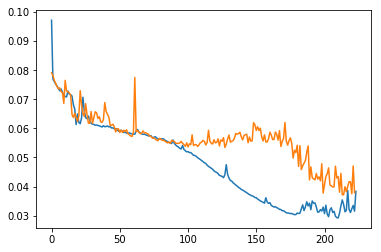

최-----------------드-은 사-몬-조-저--가-르-가ᅡ      온-거--자-- 거--다-ᄉ수-면      시--으-저-이 간여-ᅡᅡ는 거-ᄉᄋᄅ를 다--하--해---ᆻᆻ------------다..<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
최드은 사몬조저가르가 온거자 거다수면 시으저이 간여ᅡ는 거ᄉᄋ를 다하했다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


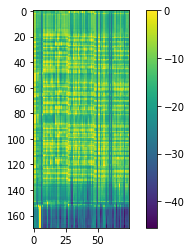

우--------------------ᅵ-ᄀ가-기-이있는 그-꾼응은 상-궁-ᅳᅳᅵᅵᅵ   이-영은 ᄉ-ᄉᄉ이  캐ᄒ언근-그--이----ᆸᆸ-----------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᅵ가기이있는 그꾼응은 상궁ᅳᅵ 이영은 ᄉᄉ이 캐ᄒ언근그입니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


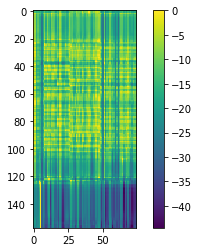

-------------------------------------------------------------------------------------------------------
09-01 12:02:15
Mean Train Loss: 0.03170592237614122
Mean Evaluation Loss: 0.043107128707968775
-------------------------------------------------------------------------------------------------------
09-01 12:02:35
Mean Train Loss: 0.03297169630130358
Mean Evaluation Loss: 0.038232430000203196
-------------------------------------------------------------------------------------------------------
09-01 12:02:55
Mean Train Loss: 0.03159101741051928
Mean Evaluation Loss: 0.03629944121441695
-------------------------------------------------------------------------------------------------------
09-01 12:03:16
Mean Train Loss: 0.029475699524589543
Mean Evaluation Loss: 0.040306099515203815
-------------------------------------------------------------------------------------------------------
09-01 12:03:36
Mean Train Loss: 0.03071550780043117
Mean Evaluation Loss: 0.03595484137412123
------

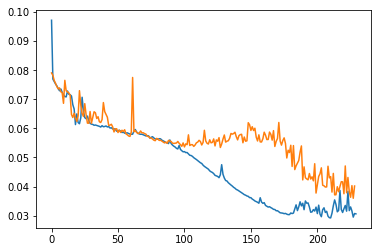

자------------------긴-에  지-에에ᅦ안-ᅡᅡᆫ는 버ᅥᄅᄀ--이-지ᅵ-닌 나--다--.  ---자--이-ᄂ는 난-지ᅵ--    보--펴ᅧᆼ 저-지ᅵᆨ 작--뎌-를 시--이--------이다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
자긴에 지에에안ᅡᆫ는 버ᄅᄀ이지닌 나다. 자이는 난지 보평 저직 작뎌를 시이이다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


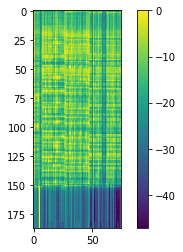

한----------------국인 구-묵-ᅳ-는      석-식그-이-니--  어-마-은 고-이 욱가--은 곳-가----ᇀ-------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
한국인 구묵ᅳ는 석식그이니 어마은 고이 욱가은 곳같아요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


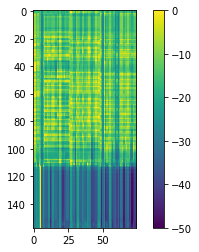

-------------------------------------------------------------------------------------------------------
09-01 12:04:17
Mean Train Loss: 0.030444241818352893
Mean Evaluation Loss: 0.054273487494614525
-------------------------------------------------------------------------------------------------------
09-01 12:04:37
Mean Train Loss: 0.03908145191310673
Mean Evaluation Loss: 0.045197800747646975
-------------------------------------------------------------------------------------------------------
09-01 12:04:58
Mean Train Loss: 0.03604950227033269
Mean Evaluation Loss: 0.041938246497348286
-------------------------------------------------------------------------------------------------------
09-01 12:05:19
Mean Train Loss: 0.033499239793770154
Mean Evaluation Loss: 0.0372048899569824
-------------------------------------------------------------------------------------------------------
09-01 12:05:39
Mean Train Loss: 0.03975279998673876
Mean Evaluation Loss: 0.04372077428769775
------

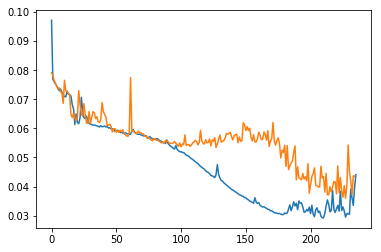

이 ---------------티ᄋᄋᄋ이ᄉ시-ᄋᄋ 사ᅡ의 ᄉ서-자-는   이-기- 지이 십 자ᄋᄋ ᄉ시에-이--다-     -------가ᅡ--서--자-에-아-번 파-이-가-      ----이-ᅵᅵ--자-------------든.<eos><eos><eos><eos><eos><eos>
이 티이시ᄋ 사의 서자는 이기 지이 십 자ᄋ 시에이다 가서자에아번 파이가 이ᅵ자든.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


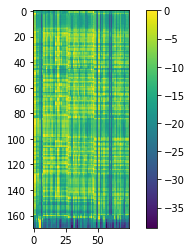

그 -----------------ᄉ사-항함우 심믄이-자ᅡ-만 이ᅵ이 에- 강니--에---,         ᅡᅡ-우--순은 ᄀᆼ-어-인 히이ᅵᅵ-ᄋ아--------------------이야.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그 사항함우 심믄이자만 이이 에 강니에, ᅡ우순은 ᄀᆼ어인 히이아이야.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


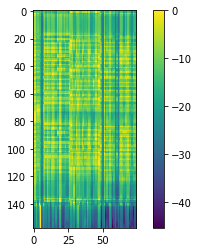

-------------------------------------------------------------------------------------------------------
09-01 12:06:20
Mean Train Loss: 0.037179874901255086
Mean Evaluation Loss: 0.03900088902472958
-------------------------------------------------------------------------------------------------------
09-01 12:06:39
Mean Train Loss: 0.03382358131292538
Mean Evaluation Loss: 0.03862322593904434
-------------------------------------------------------------------------------------------------------
09-01 12:06:59
Mean Train Loss: 0.04606247504223901
Mean Evaluation Loss: 0.07460218618869179
-------------------------------------------------------------------------------------------------------
09-01 12:07:20
Mean Train Loss: 0.06648055025078872
Mean Evaluation Loss: 0.06573751121018649
-------------------------------------------------------------------------------------------------------
09-01 12:07:40
Mean Train Loss: 0.06633479239451201
Mean Evaluation Loss: 0.06549449177276918
---------

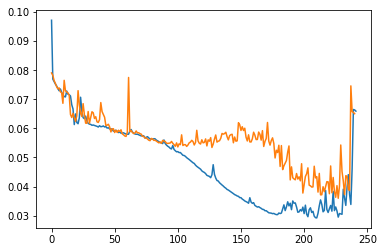

으------------------으-인--ᅳ --ᅳ---으-이-으---ᅡ--이-이-으--ᄋ--------- ᄋ-----아--ᄋ-아-아- ᅡ-ᄋ--------ᄋ- ᅡ--ᅡ-아-ᄋ-아--ᅡ-------------ᅵ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
으으인ᅳ ᅳ으이으ᅡ이이으ᄋ ᄋ아ᄋ아아 ᅡᄋᄋ ᅡᅡ아ᄋ아ᅡᅵ다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


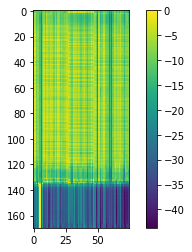

아--------------------------------ᅳ--ᅳ-----ᅡ--ᅳ-이--ᅵ-이- ᅵ-이-이-이---------------이-이-아-아- ᅵ-이- ᅵ-이-아- ᅡ--ᅡ------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᅳᅳᅡᅳ이ᅵ이 ᅵ이이이이이아아 ᅵ이 ᅵ이아 ᅡᅡ니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


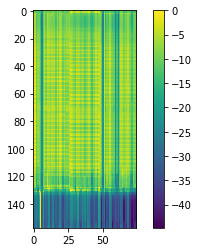

-------------------------------------------------------------------------------------------------------
09-01 12:08:20
Mean Train Loss: 0.064583887407853
Mean Evaluation Loss: 0.06240524355865845
-------------------------------------------------------------------------------------------------------
09-01 12:08:40


KeyboardInterrupt: ignored

In [26]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_test.initialize_batch()
    loss_list_eval = list()
    
    while preloader_test.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_test.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")